# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

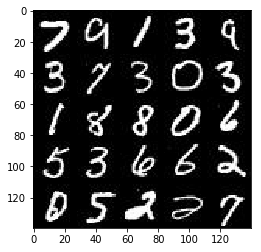

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

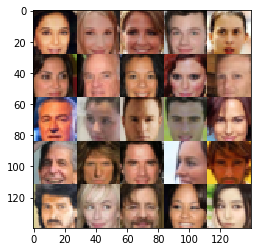

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_imgs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_imgs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Image size is 28x28x(1 - MNIST, 3 - celeb)
        l1 = tf.layers.conv2d(images, 
                                 64, 
                                 3, 
                                 strides=2, 
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        l1 = tf.maximum(l1 * alpha, l1)
        d1 = tf.layers.dropout(l1, rate=0.8)
        
        
        # Image 7x7x128 
        l2 = tf.layers.conv2d(d1, 
                                 128, 
                                 3, 
                                 strides=2, 
                                 padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(l2 * alpha, l2)
        d2 = tf.layers.dropout(l2, rate=0.8)
        

        # Image 4x4x25
        l3 = tf.layers.conv2d(d2, 
                                 256, 
                                 3, 
                                 strides=2,
                                 padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(l3 * alpha, l3)
        d3 = tf.layers.dropout(l3, rate=0.8)
        

        flat = tf.reshape(d3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)

        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
    
        l1 = tf.layers.dense(z, 7 * 7 * 512)
        # Reshaping
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        l2 = tf.layers.dropout(l2, rate=0.5)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        l3 = tf.layers.dropout(l3, rate=0.5)
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(alpha * l4, l4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)

    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_r, d_logits_r = discriminator(input_real)
    d_model_f, d_logits_f = discriminator(g_model, reuse=True)
    
    #d_loss_r = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_r, labels=tf.ones_like(d_model_r)))
    d_loss_r = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_r, labels=tf.ones_like(d_model_r)*0.9))
    d_loss_f = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.zeros_like(d_model_f)*0.9))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.ones_like(d_model_f)))
    
    d_loss = d_loss_r + d_loss_f

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every=100
    learning=learning_rate
    img_width=data_shape[1]
    img_height=data_shape[2]
    img_channels=data_shape[3]
    out_channel_dim=data_shape[3]
    
    input_real,input_z,learning=model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, out_channel_dim)
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #print(np.max(batch_images)) = 0.5
                #print(np.min(batch_images)) = -0.5
                # Since the value of my batch images is
                scaled_image_input = 2 * batch_images # scaling the image as it was between [-0.5, 0.5]
                
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: scaled_image_input , input_z: batch_z, learning:learning_rate})
                _ = sess.run(g_opt, feed_dict={ input_real: scaled_image_input,input_z: batch_z, learning:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: scaled_image_input, input_z: batch_z, learning:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: scaled_image_input,input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                    
    
    print("Training completed.")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.0572... Generator Loss: 0.0767
Epoch 1/2... Discriminator Loss: 2.9452... Generator Loss: 0.0849
Epoch 1/2... Discriminator Loss: 2.1124... Generator Loss: 0.2108
Epoch 1/2... Discriminator Loss: 1.7987... Generator Loss: 0.2920
Epoch 1/2... Discriminator Loss: 1.6480... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 2.9584... Generator Loss: 0.0896
Epoch 1/2... Discriminator Loss: 1.8835... Generator Loss: 0.2613
Epoch 1/2... Discriminator Loss: 1.6309... Generator Loss: 0.3381
Epoch 1/2... Discriminator Loss: 1.5068... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.7903


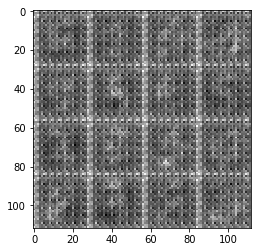

Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 1.6420... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.3162
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.9470
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.6111
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.4254... Generator Loss: 0.5166


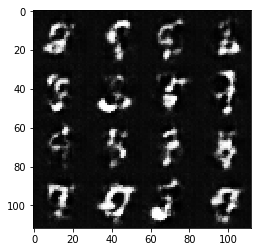

Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.9052
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 1.6742... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 1.7567... Generator Loss: 0.3016
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.5882
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 1.6638... Generator Loss: 0.3392


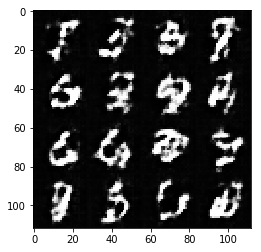

Epoch 1/2... Discriminator Loss: 1.9985... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.6769... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.7034... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4683
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.4560... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 2.6249... Generator Loss: 0.1181


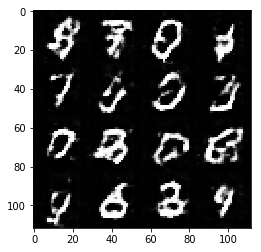

Epoch 1/2... Discriminator Loss: 2.1164... Generator Loss: 0.2046
Epoch 1/2... Discriminator Loss: 1.7531... Generator Loss: 0.3603
Epoch 1/2... Discriminator Loss: 1.9102... Generator Loss: 0.2838
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.3967
Epoch 1/2... Discriminator Loss: 1.4508... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.7256... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 2.4218... Generator Loss: 0.1563
Epoch 1/2... Discriminator Loss: 1.8579... Generator Loss: 0.3000
Epoch 1/2... Discriminator Loss: 1.7319... Generator Loss: 0.4219
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 1.0241


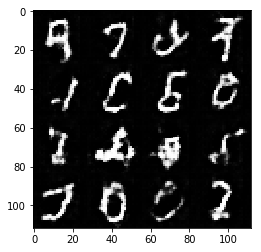

Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.9707... Generator Loss: 0.2550
Epoch 1/2... Discriminator Loss: 2.1086... Generator Loss: 0.2245
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 1.5372... Generator Loss: 0.6970
Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.3533
Epoch 1/2... Discriminator Loss: 2.0808... Generator Loss: 0.2194
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.9182


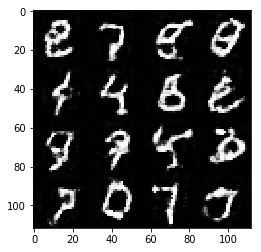

Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.5845... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 1.9714... Generator Loss: 0.2536
Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.6331
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.4084
Epoch 1/2... Discriminator Loss: 1.8132... Generator Loss: 0.3118
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.4684


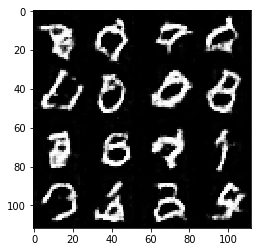

Epoch 1/2... Discriminator Loss: 2.1861... Generator Loss: 0.1883
Epoch 1/2... Discriminator Loss: 1.6990... Generator Loss: 0.3761
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.6480... Generator Loss: 0.4147
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 2.4731... Generator Loss: 0.1378
Epoch 1/2... Discriminator Loss: 1.6479... Generator Loss: 0.3851
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.6420


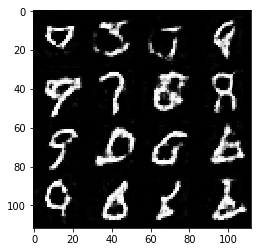

Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.2486... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 1.8542... Generator Loss: 0.2906
Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.6578... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 1.1696
Epoch 1/2... Discriminator Loss: 1.7098... Generator Loss: 0.3249
Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.7663... Generator Loss: 0.3158


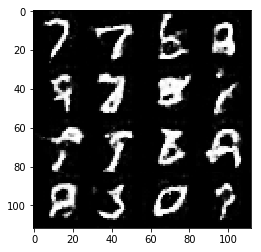

Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.4363
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.4390
Epoch 1/2... Discriminator Loss: 1.7552... Generator Loss: 0.3075
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.8431... Generator Loss: 0.2992
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.4126


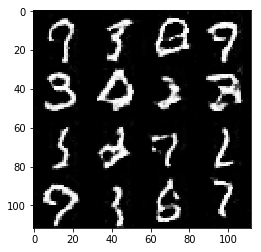

Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.3466... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.8449... Generator Loss: 0.2909
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.7370... Generator Loss: 0.3467
Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.6854


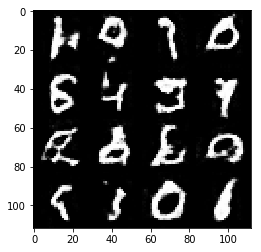

Epoch 1/2... Discriminator Loss: 1.7103... Generator Loss: 0.3407
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.4728
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 1.4233... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.7701... Generator Loss: 0.3189
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.8096... Generator Loss: 0.3102


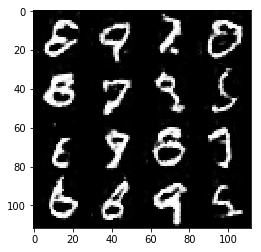

Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 1.1372... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.9439


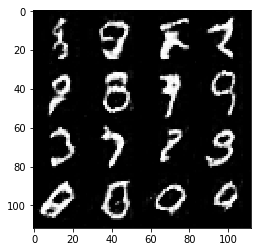

Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 1.5782
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 2.1843... Generator Loss: 0.1963
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 1.8814... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 2.1656... Generator Loss: 0.1944
Epoch 1/2... Discriminator Loss: 1.6020... Generator Loss: 0.3931


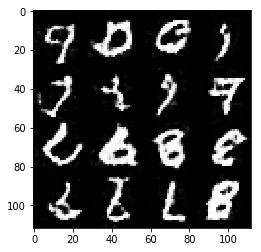

Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.5682
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.4911
Epoch 1/2... Discriminator Loss: 1.4154... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.3283... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.5236... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.6529


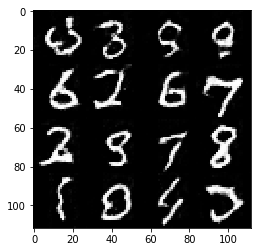

Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 2.0189... Generator Loss: 0.2362
Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4248
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 1.7931... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.5985


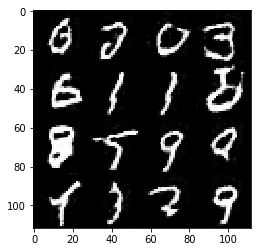

Epoch 1/2... Discriminator Loss: 1.5910... Generator Loss: 0.4009
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.8702... Generator Loss: 0.2828
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.4547
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 1.6453... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.5359


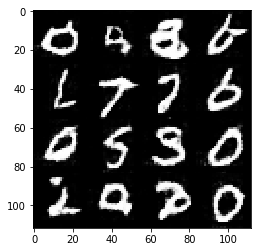

Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 1.6235
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.9686
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 0.5319
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 0.8936


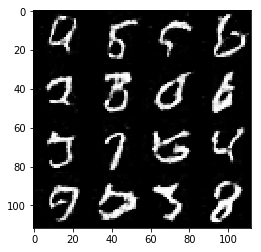

Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.8468... Generator Loss: 0.2948
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.9068... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 1.5924... Generator Loss: 0.4085
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 1.2337
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.8008


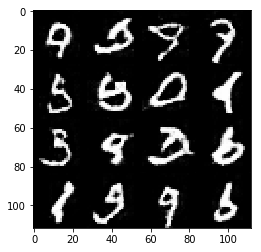

Epoch 2/2... Discriminator Loss: 2.1332... Generator Loss: 0.2121
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.0705
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.5381
Epoch 2/2... Discriminator Loss: 1.7443... Generator Loss: 0.3388


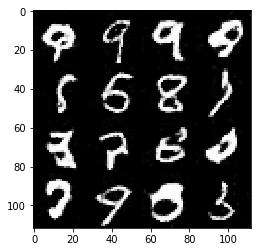

Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.5689
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.2853
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.0225
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.5566
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.5643
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.5985
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.9635


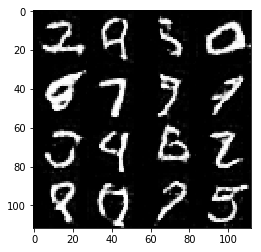

Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.6910
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 1.2924... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 1.5086... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.4916
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.1166


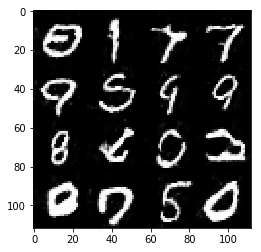

Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.5062... Generator Loss: 0.4301
Epoch 2/2... Discriminator Loss: 1.6214... Generator Loss: 0.3655
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.5769
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.7279


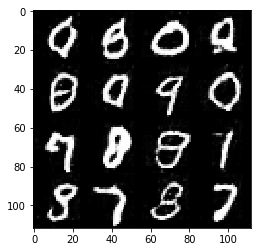

Epoch 2/2... Discriminator Loss: 1.8445... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.4233
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.8106... Generator Loss: 0.3012
Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.5775


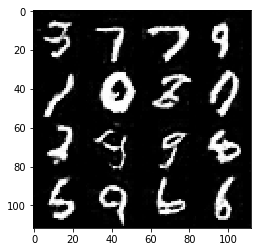

Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.4814... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.4845
Epoch 2/2... Discriminator Loss: 1.8116... Generator Loss: 0.3175
Epoch 2/2... Discriminator Loss: 1.6383... Generator Loss: 0.4112
Epoch 2/2... Discriminator Loss: 1.7791... Generator Loss: 0.3301
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.5410
Epoch 2/2... Discriminator Loss: 1.5424... Generator Loss: 0.4396
Epoch 2/2... Discriminator Loss: 1.8387... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.5197


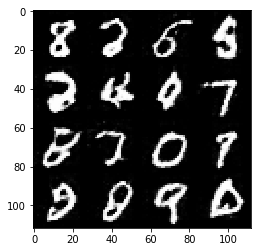

Epoch 2/2... Discriminator Loss: 1.5734... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.7977
Epoch 2/2... Discriminator Loss: 1.6614... Generator Loss: 0.3957
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.4914
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.5757... Generator Loss: 0.3960
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.8710


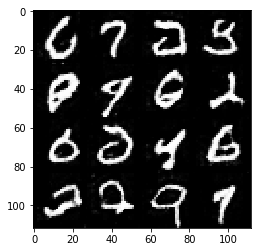

Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.6325... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.5423
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.5498
Epoch 2/2... Discriminator Loss: 1.8117... Generator Loss: 0.3131
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.7794


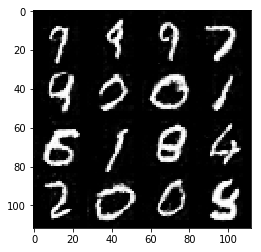

Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.4709
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 1.5876... Generator Loss: 0.4352
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.7742
Epoch 2/2... Discriminator Loss: 1.2731... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.6109
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.7050


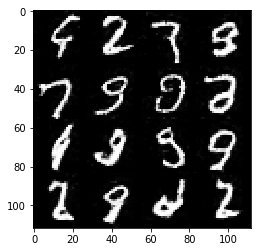

Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 0.9645... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.2823... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.5700
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.6136


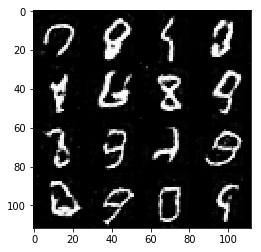

Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.5329
Epoch 2/2... Discriminator Loss: 1.6198... Generator Loss: 0.3975
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 1.6445... Generator Loss: 0.3809
Epoch 2/2... Discriminator Loss: 1.6408... Generator Loss: 0.4065
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.6786


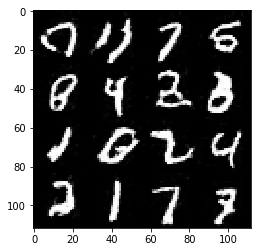

Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.7854
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 1.8691... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.4476
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.6941
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.8995


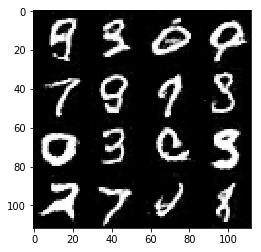

Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.5799... Generator Loss: 0.4170
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.7117
Epoch 2/2... Discriminator Loss: 1.7956... Generator Loss: 0.2980
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.5904... Generator Loss: 0.4072
Epoch 2/2... Discriminator Loss: 0.8603... Generator Loss: 1.2483
Epoch 2/2... Discriminator Loss: 1.6481... Generator Loss: 0.3835
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.7496


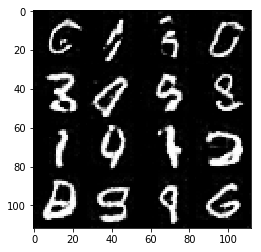

Epoch 2/2... Discriminator Loss: 2.3451... Generator Loss: 0.1874
Epoch 2/2... Discriminator Loss: 1.5541... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 1.2807... Generator Loss: 0.5526
Epoch 2/2... Discriminator Loss: 1.5681... Generator Loss: 0.3968
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7933


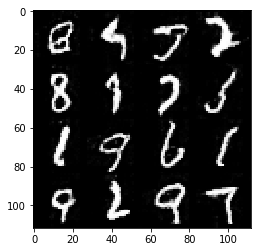

Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.9933
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.2181... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.3715
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.7435
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.6618
Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 0.9674


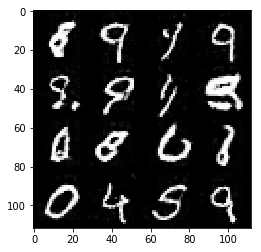

Epoch 2/2... Discriminator Loss: 0.9774... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.8358
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.1078
Epoch 2/2... Discriminator Loss: 1.7102... Generator Loss: 0.3527
Epoch 2/2... Discriminator Loss: 1.5187... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.6384


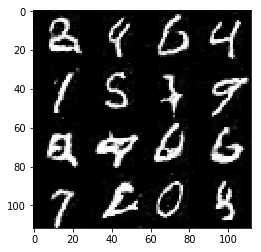

Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.5531... Generator Loss: 0.4035
Epoch 2/2... Discriminator Loss: 0.9881... Generator Loss: 0.9953
Epoch 2/2... Discriminator Loss: 1.3751... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 1.0491
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.6640


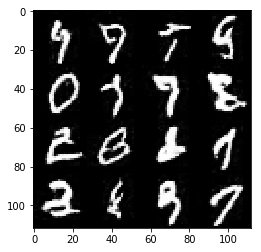

Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 1.1379... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.5225
Epoch 2/2... Discriminator Loss: 1.1843... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 1.6691... Generator Loss: 0.3780
Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 1.2338


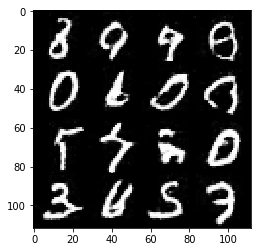

Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 0.4348
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 0.9772
Training completed.


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7315... Generator Loss: 0.0164
Epoch 1/1... Discriminator Loss: 3.8759... Generator Loss: 0.0346
Epoch 1/1... Discriminator Loss: 3.8373... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 3.3092... Generator Loss: 0.0608
Epoch 1/1... Discriminator Loss: 3.3359... Generator Loss: 0.0596
Epoch 1/1... Discriminator Loss: 2.7884... Generator Loss: 0.1003
Epoch 1/1... Discriminator Loss: 2.2573... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 2.5510... Generator Loss: 0.1474
Epoch 1/1... Discriminator Loss: 1.9957... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 2.7502... Generator Loss: 0.1103


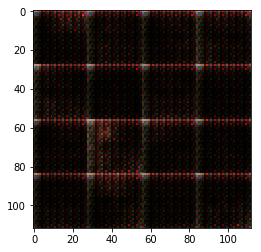

Epoch 1/1... Discriminator Loss: 2.2255... Generator Loss: 0.2737
Epoch 1/1... Discriminator Loss: 2.4318... Generator Loss: 0.1761
Epoch 1/1... Discriminator Loss: 2.4019... Generator Loss: 0.2533
Epoch 1/1... Discriminator Loss: 2.0527... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 2.4346... Generator Loss: 0.1826
Epoch 1/1... Discriminator Loss: 2.3758... Generator Loss: 0.2223
Epoch 1/1... Discriminator Loss: 1.8747... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 2.3827... Generator Loss: 0.2364
Epoch 1/1... Discriminator Loss: 2.3260... Generator Loss: 0.1785
Epoch 1/1... Discriminator Loss: 2.1758... Generator Loss: 0.3197


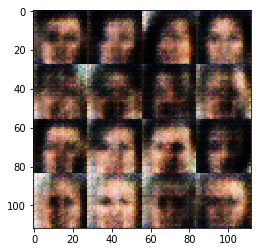

Epoch 1/1... Discriminator Loss: 2.5907... Generator Loss: 0.1495
Epoch 1/1... Discriminator Loss: 1.9017... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 2.0927... Generator Loss: 0.2899
Epoch 1/1... Discriminator Loss: 2.4718... Generator Loss: 0.1536
Epoch 1/1... Discriminator Loss: 2.3839... Generator Loss: 0.2021
Epoch 1/1... Discriminator Loss: 2.4256... Generator Loss: 0.2134
Epoch 1/1... Discriminator Loss: 2.2374... Generator Loss: 0.2397
Epoch 1/1... Discriminator Loss: 1.8530... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 1.9608... Generator Loss: 0.2823
Epoch 1/1... Discriminator Loss: 1.8871... Generator Loss: 0.3908


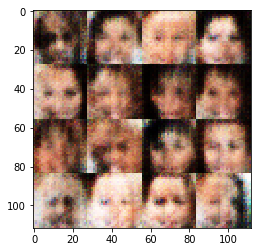

Epoch 1/1... Discriminator Loss: 2.1399... Generator Loss: 0.2666
Epoch 1/1... Discriminator Loss: 1.9874... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 1.9752... Generator Loss: 0.3290
Epoch 1/1... Discriminator Loss: 2.0969... Generator Loss: 0.3021
Epoch 1/1... Discriminator Loss: 1.7752... Generator Loss: 0.3234
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.7949... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 2.2066... Generator Loss: 0.3204
Epoch 1/1... Discriminator Loss: 1.9505... Generator Loss: 0.3458
Epoch 1/1... Discriminator Loss: 1.8485... Generator Loss: 0.4067


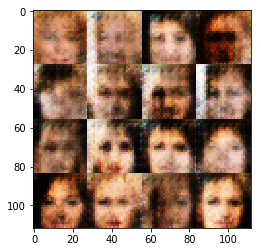

Epoch 1/1... Discriminator Loss: 2.3723... Generator Loss: 0.2057
Epoch 1/1... Discriminator Loss: 2.1886... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.9134... Generator Loss: 0.3508
Epoch 1/1... Discriminator Loss: 2.0220... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 2.0793... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 2.5270... Generator Loss: 0.2681
Epoch 1/1... Discriminator Loss: 1.8633... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.9376... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.8929... Generator Loss: 0.4333
Epoch 1/1... Discriminator Loss: 2.3347... Generator Loss: 0.2576


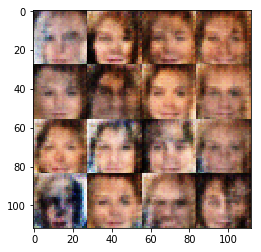

Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 0.3660
Epoch 1/1... Discriminator Loss: 1.9184... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.9488... Generator Loss: 0.3342
Epoch 1/1... Discriminator Loss: 1.8308... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 2.0307... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.8265... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.9506... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.8441... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 2.0635... Generator Loss: 0.3423


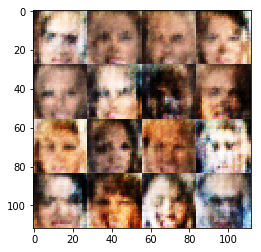

Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 2.1955... Generator Loss: 0.3220
Epoch 1/1... Discriminator Loss: 1.9799... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.8092... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.7997... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.9991... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.8333... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 1.8682... Generator Loss: 0.5222


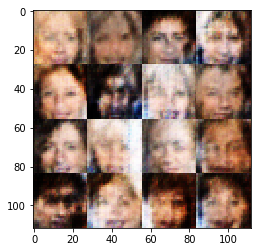

Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.4500
Epoch 1/1... Discriminator Loss: 1.9244... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.8099... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 1.7360... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.4599


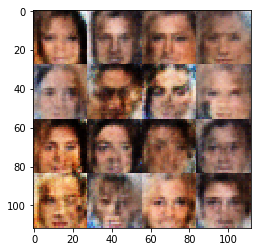

Epoch 1/1... Discriminator Loss: 1.9269... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.9454... Generator Loss: 0.3782
Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.9225... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.6957... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.8018... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.7839... Generator Loss: 0.4735


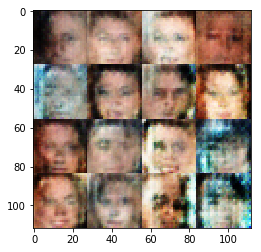

Epoch 1/1... Discriminator Loss: 1.7914... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.7690... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.7592... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.6609... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.8027... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 1.6807... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.7088... Generator Loss: 0.4858


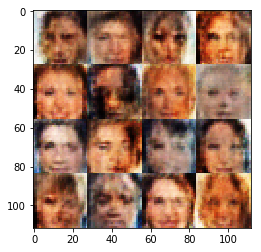

Epoch 1/1... Discriminator Loss: 1.7502... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.7966... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.7377... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.8783... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 0.5012


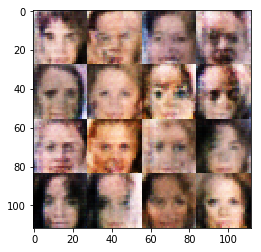

Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.4929
Epoch 1/1... Discriminator Loss: 1.6271... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.6674... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.7486... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.6866... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.6006... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.5543


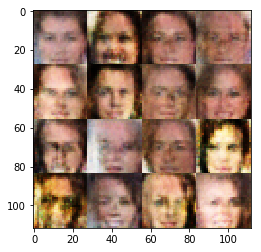

Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.6876... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.7121... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.7138... Generator Loss: 0.5114


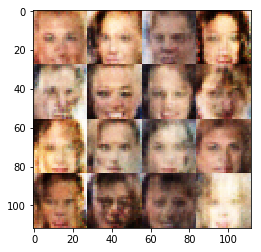

Epoch 1/1... Discriminator Loss: 1.6781... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.7834... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.6484


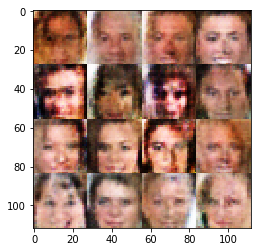

Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.6925... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6694


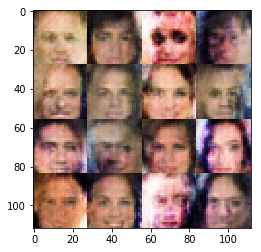

Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.6145... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.6537... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5403


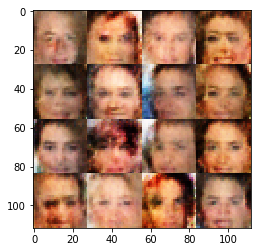

Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.7027... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.5303


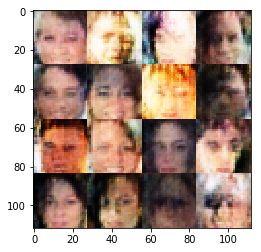

Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.6083


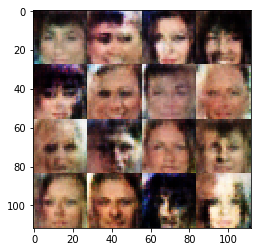

Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.6493... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.6249... Generator Loss: 0.5644


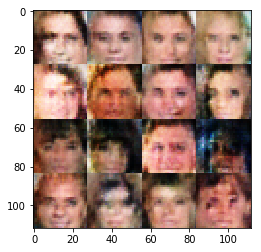

Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.6574... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.4779


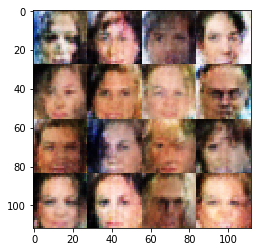

Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.7152... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.5408


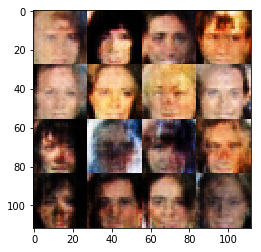

Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.6154... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.5798


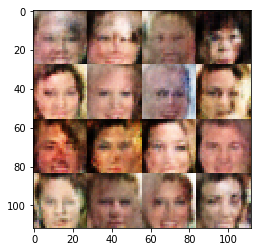

Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.5897


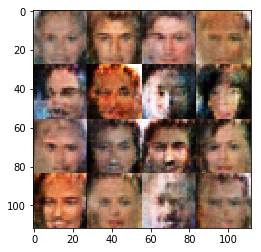

Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6462


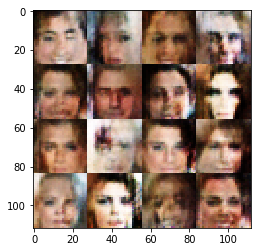

Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.6053


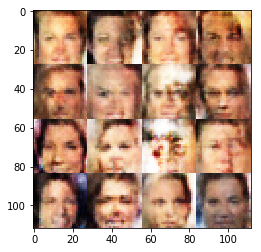

Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.7841... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5544


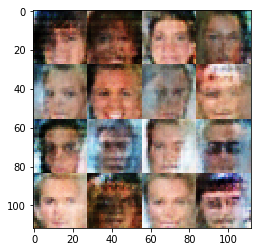

Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.6820... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.6147


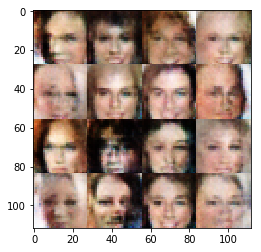

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.6160... Generator Loss: 0.6074


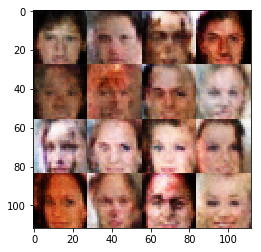

Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.5958


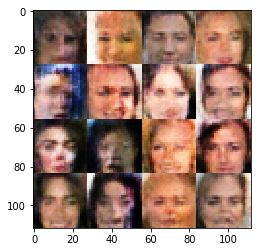

Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.5818


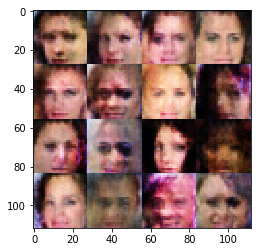

Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.5895


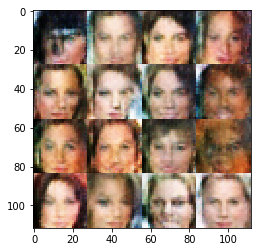

Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5982... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.5494


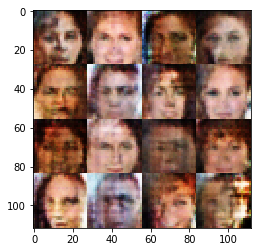

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.5740


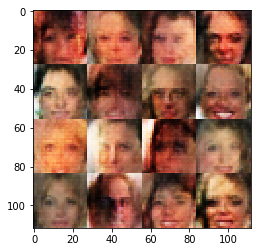

Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.6046


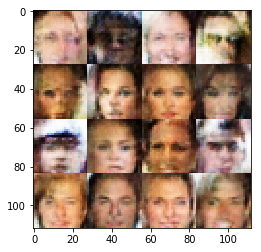

Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.6602... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5717


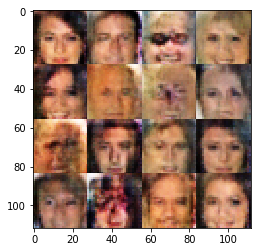

Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.6749... Generator Loss: 0.5180
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6459


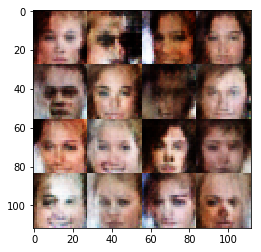

Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.5796... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.6140


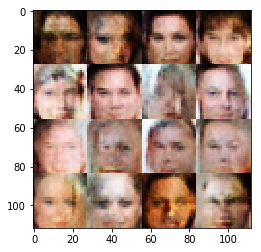

Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.6252


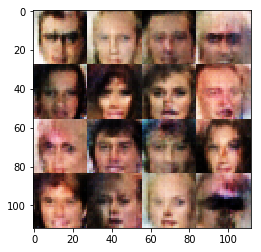

Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5580


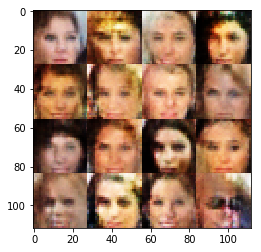

Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6424


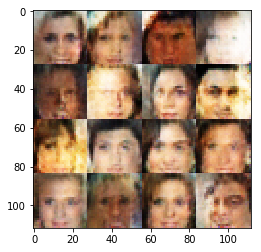

Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.6311


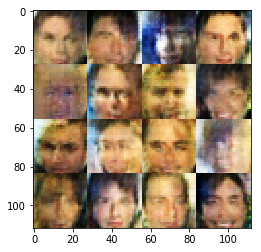

Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6763


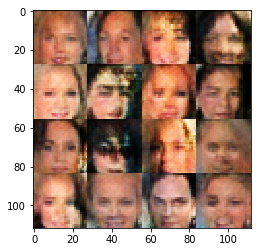

Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.6311... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.6299


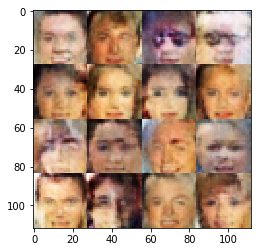

Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.6009


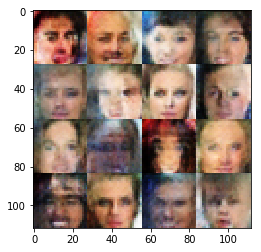

Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6712


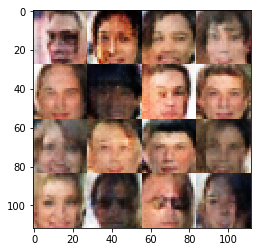

Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7054


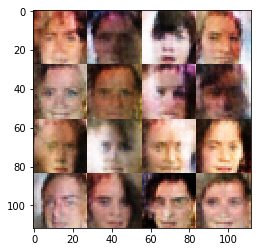

Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.6099


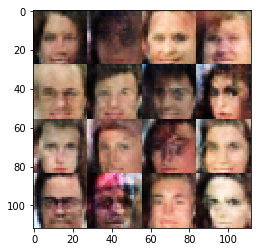

Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.5781


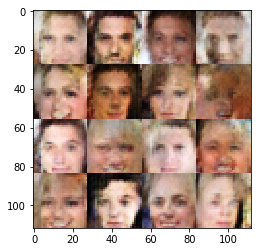

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5190... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.5969


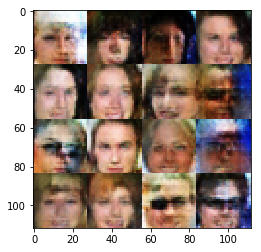

Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7667


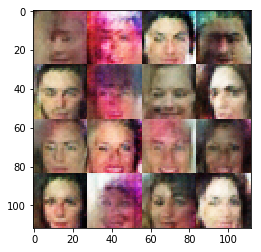

Epoch 1/1... Discriminator Loss: 1.6699... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6551


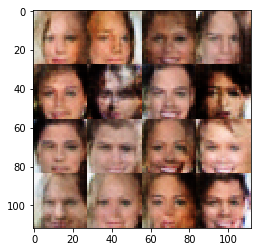

Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.5816... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5957


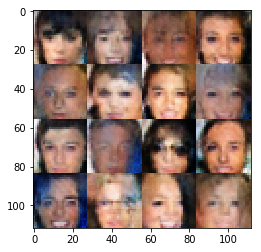

Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5938


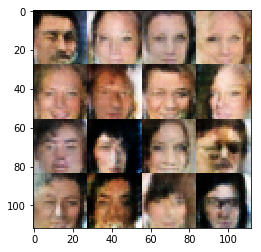

Epoch 1/1... Discriminator Loss: 1.5836... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6543


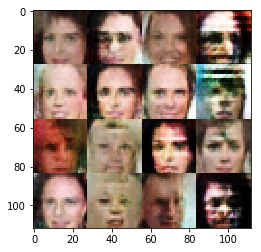

Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6550


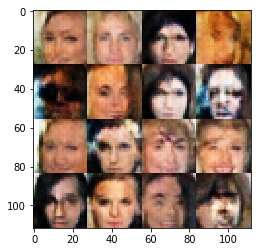

Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.5847
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5999


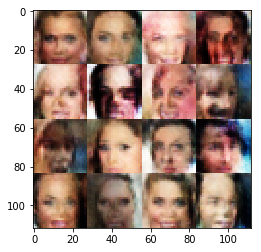

Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.5883


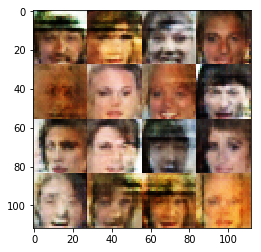

Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.6331


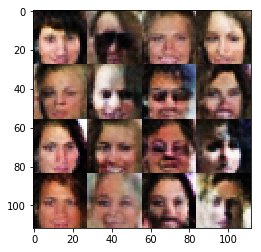

Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.5847


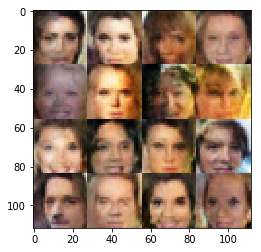

Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.5667


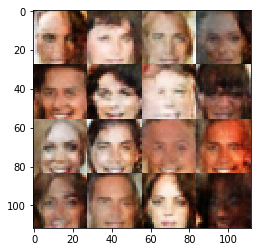

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.8007... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6585


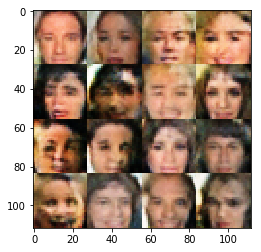

Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.5230
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.5983


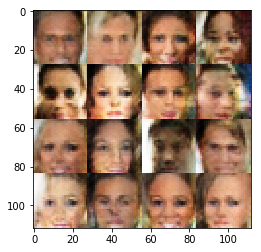

Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6256


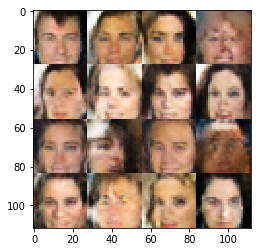

Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.7737... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6326


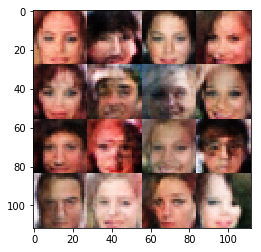

Epoch 1/1... Discriminator Loss: 1.7635... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6299


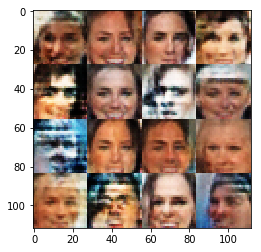

Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.7743... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.5805


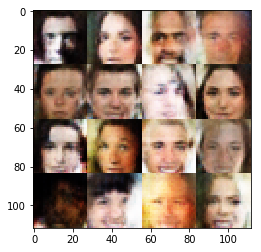

Epoch 1/1... Discriminator Loss: 1.5644... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.6485... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6036


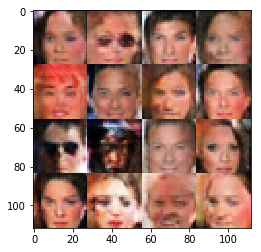

Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.5430


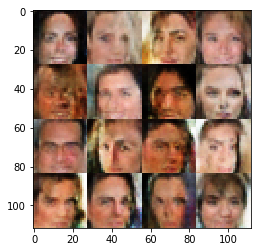

Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.7015... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.4931


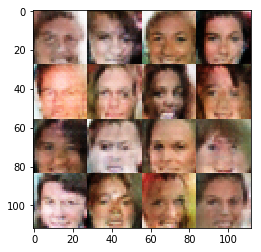

Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.6068


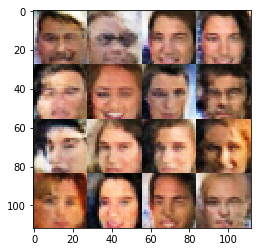

Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.7225... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.5189


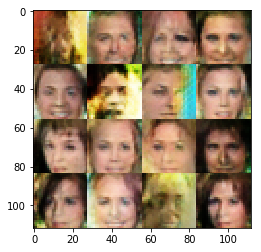

Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.8241... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5709


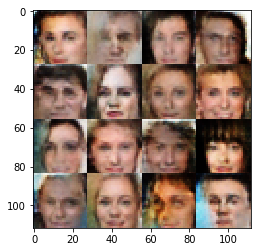

Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.9076... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.5682


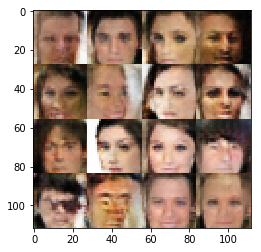

Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7142


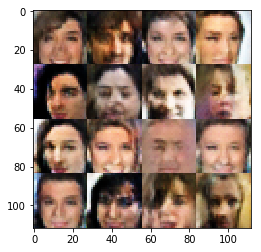

Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.6032... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.7082... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.6853... Generator Loss: 0.5509


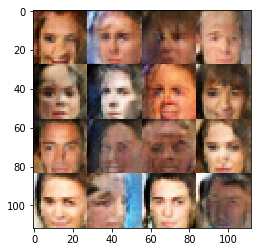

Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.7160... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.6036


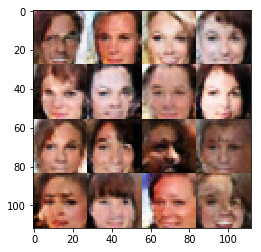

Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.5696


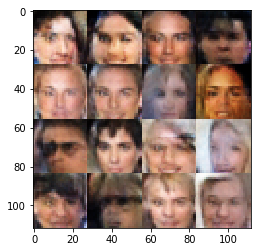

Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5552


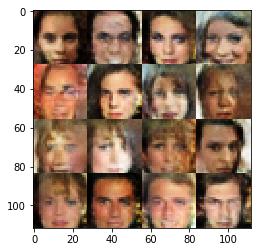

Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.6248... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.5528


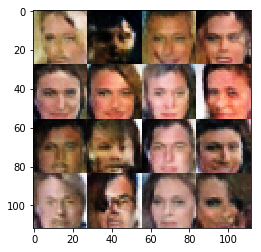

Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.5785


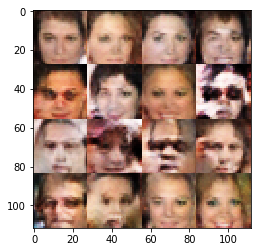

Epoch 1/1... Discriminator Loss: 1.5996... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6476


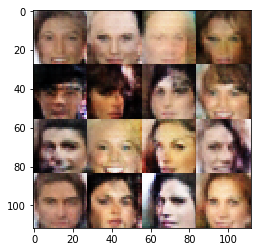

Epoch 1/1... Discriminator Loss: 1.6291... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.5198


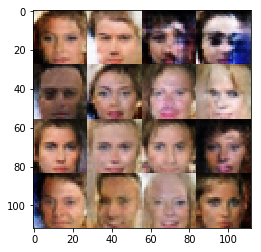

Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.5455
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.4797


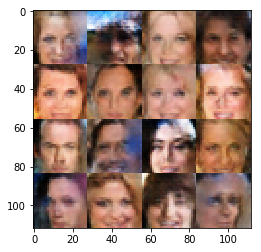

Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.5817


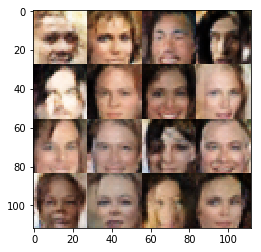

Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.6132... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.7581... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6477


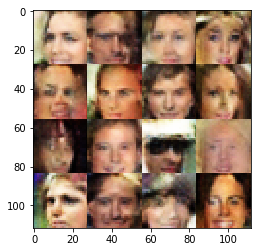

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.6144... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.5957... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.5632


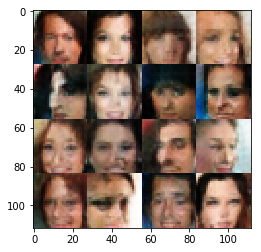

Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.6988... Generator Loss: 0.4768
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5872


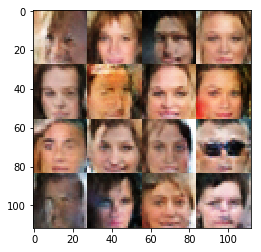

Epoch 1/1... Discriminator Loss: 1.8091... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.5955... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.7854... Generator Loss: 0.4346


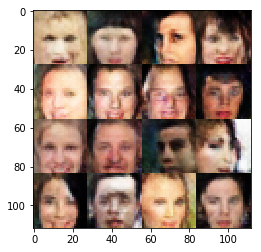

Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.7523... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.7796... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.7099... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.5156


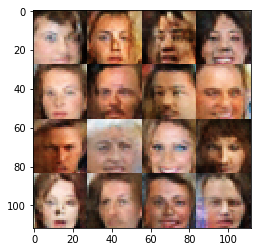

Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.7320... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.4892


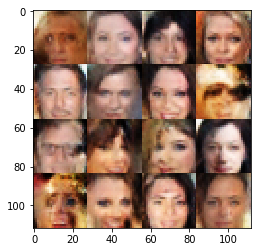

Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5948


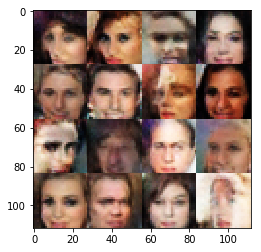

Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 0.4037
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5537


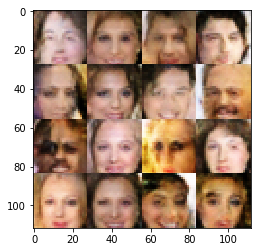

Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.7042... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.6633... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.4973


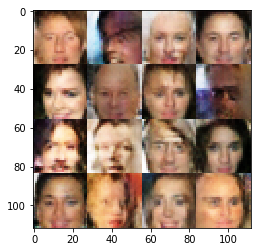

Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 0.4118
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.4520
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.7023... Generator Loss: 0.4436


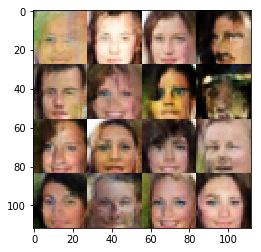

Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.7316... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.7505... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.7215... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.6681... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.7154... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 0.4776


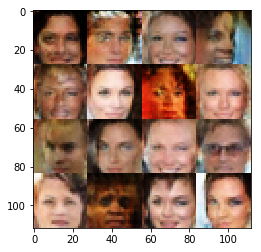

Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.9350... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.5922... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.7238... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.7086... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5413


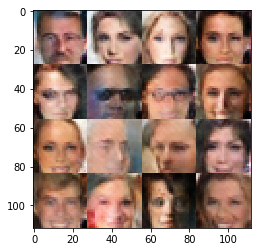

Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.8447... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.5301


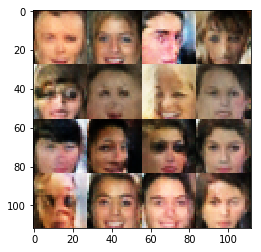

Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.7682... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.6456... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5565


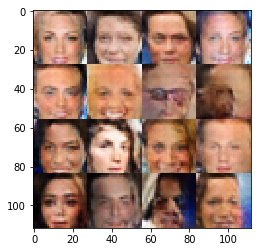

Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 2.0228... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.4724


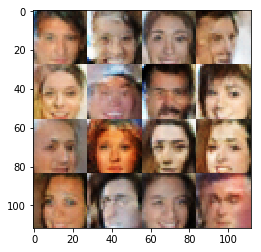

Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.5899... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.8140... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.8452... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5796


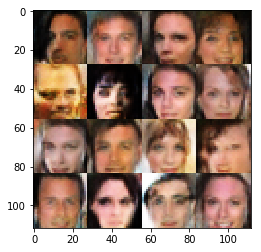

Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.4395
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.8671... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 0.4958


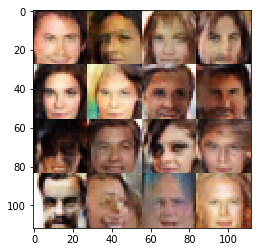

Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.4225
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.6635... Generator Loss: 0.4365


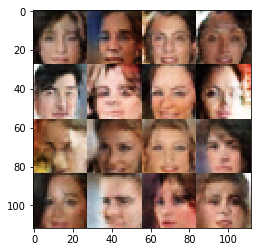

Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 2.0145... Generator Loss: 0.3851
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.5638


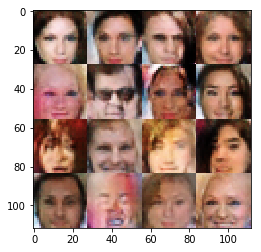

Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.7075... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.7129... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 0.4102


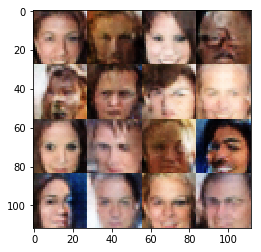

Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.6814... Generator Loss: 0.4500
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.9148... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.6766... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.7200... Generator Loss: 0.4893


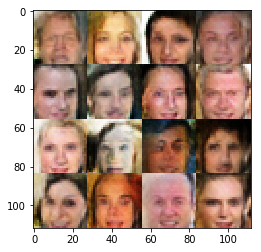

Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.6643... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.8859... Generator Loss: 0.3910
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 0.3996


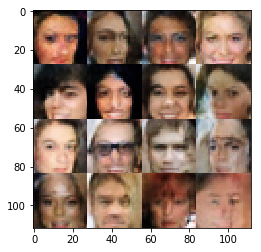

Epoch 1/1... Discriminator Loss: 1.7618... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.7980... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.8583... Generator Loss: 0.3590
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.4416


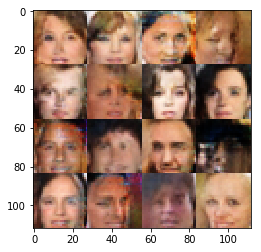

Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.8581... Generator Loss: 0.3961
Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.4398
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.8897... Generator Loss: 0.3544


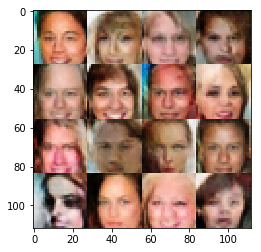

Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.8953... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 1.7725... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.7866... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.4073


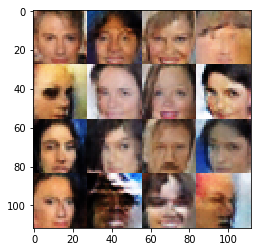

Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.9568... Generator Loss: 0.3270
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.4188


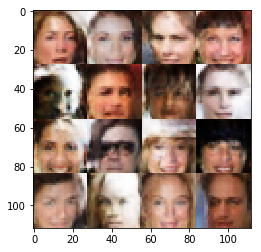

Epoch 1/1... Discriminator Loss: 1.8190... Generator Loss: 0.4018
Epoch 1/1... Discriminator Loss: 1.8227... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.9333... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.4892


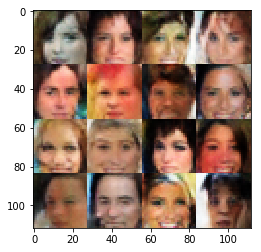

Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.9139... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 0.3827
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.6944... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.7959... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.7553... Generator Loss: 0.4162


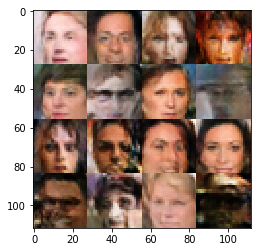

Epoch 1/1... Discriminator Loss: 1.9344... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 1.5983... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.6892... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.9955... Generator Loss: 0.3240


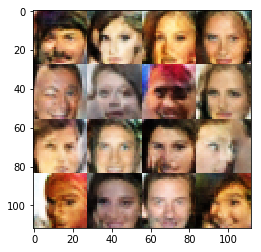

Epoch 1/1... Discriminator Loss: 1.7588... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.6029... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.7939... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 2.7112... Generator Loss: 0.1766
Epoch 1/1... Discriminator Loss: 1.9197... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.7735... Generator Loss: 0.4028


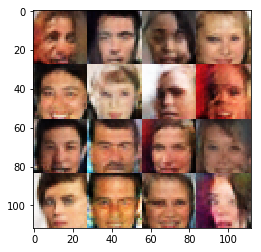

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 2.0550... Generator Loss: 0.3100


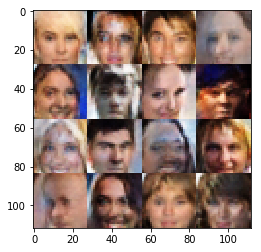

Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.8306... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 2.0403... Generator Loss: 0.3172
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.7130... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.7498... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 0.4909


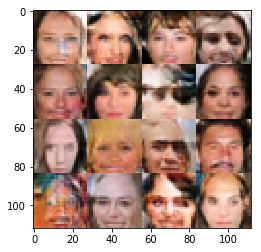

Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 0.3874
Epoch 1/1... Discriminator Loss: 1.7071... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.7405... Generator Loss: 0.4177
Epoch 1/1... Discriminator Loss: 1.9092... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6350


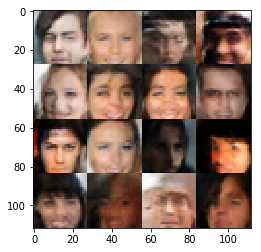

Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.7242... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.8067... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.6240... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 2.3568... Generator Loss: 0.2272
Epoch 1/1... Discriminator Loss: 1.7935... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 0.4653


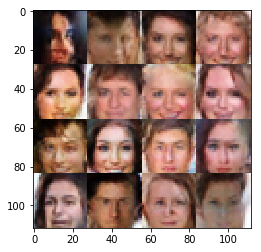

Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.7208... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.9582... Generator Loss: 0.3317
Epoch 1/1... Discriminator Loss: 1.8884... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.7236... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.4026


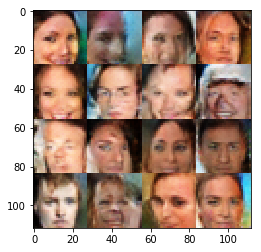

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.8281... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6064


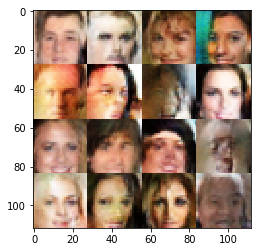

Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.6549... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 1.7671... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 0.3732
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.8464... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.9713... Generator Loss: 0.3614


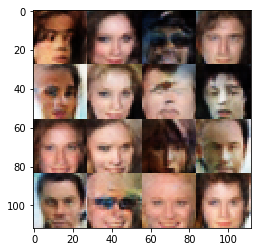

Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.7570... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.8974... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.8391... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.8151... Generator Loss: 0.3757
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.4223


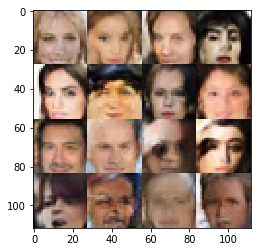

Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.4054
Epoch 1/1... Discriminator Loss: 2.1552... Generator Loss: 0.2440
Epoch 1/1... Discriminator Loss: 1.8277... Generator Loss: 0.3622
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.7954... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.4400


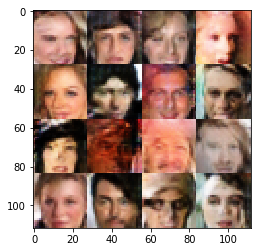

Epoch 1/1... Discriminator Loss: 1.8655... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.9054... Generator Loss: 0.3142
Epoch 1/1... Discriminator Loss: 1.6773... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.4070
Epoch 1/1... Discriminator Loss: 1.6521... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.8808... Generator Loss: 0.3620
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.7808... Generator Loss: 0.3888


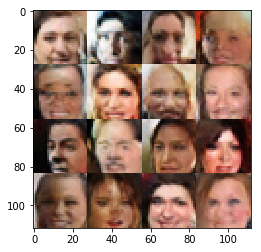

Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.7363... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.9285... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.9118... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 1.8504... Generator Loss: 0.3880
Epoch 1/1... Discriminator Loss: 1.9217... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.8273... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.9211... Generator Loss: 0.3397


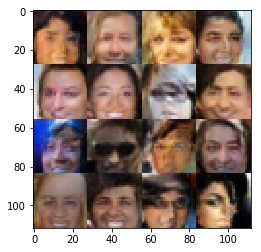

Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.9587... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 2.0138... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.6604... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.6995... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.4612


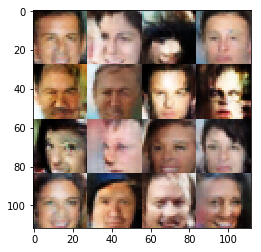

Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.8624... Generator Loss: 0.3720
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 2.1080... Generator Loss: 0.2917
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.4165
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.4426
Training completed.


In [14]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.